In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score,roc_curve, RocCurveDisplay, auc

c:\Users\Wen2Tee5\Desktop\MLProject\ML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N = 7
SPILT_RATIO = 0.8
VALIDATION_RATIO = 0.9
EPOCH = 20

In [3]:
x_data = np.load(f'./bindata/{N}-frame_x_data.npy', allow_pickle=True)
y_data = np.load(f'./bindata/{N}-frame_y_data.npy', allow_pickle=True)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size = SPILT_RATIO, shuffle = True, random_state = 76)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = VALIDATION_RATIO, shuffle = True, random_state = 76)

In [5]:
class RNN_based(torch.nn.Module):

    def __init__(self, N = N, bi = False) -> None:
        super(RNN_based, self).__init__()
        self.rnn = torch.nn.RNN(input_size = 113, hidden_size = 113, batch_first = True, bidirectional = bi)
        if (bi):
            self.h_linear = torch.nn.Linear(113 * N * 2, 64)
        else:
            self.h_linear = torch.nn.Linear(113 * N, 64)
        self.o_linear = torch.nn.Linear(64, 1)
        

    def forward(self, x):
        h_s, _ = self.rnn(x)
        h_f = torch.flatten(h_s, start_dim=1)
        h_f = torch.nn.functional.leaky_relu(h_f)
        h_f = self.h_linear(h_f)
        h_f = torch.nn.functional.leaky_relu(h_f)
        h_o = self.o_linear(h_f)
        return h_o

class LSTM_based(torch.nn.Module):

    def __init__(self, N = N, bi = False) -> None:
        super(LSTM_based, self).__init__()
        self.lstm = torch.nn.LSTM(input_size = 113, hidden_size = 113, batch_first = True, bidirectional = bi)
        if (bi):
            self.h_linear = torch.nn.Linear(113 * N * 2, 64)
        else:
            self.h_linear = torch.nn.Linear(113 * N, 64)
        self.o_linear = torch.nn.Linear(64, 1)
        

    def forward(self, x):
        h_s, (_, _) = self.lstm(x)
        h_f = torch.flatten(h_s, start_dim=1)
        h_f = torch.nn.functional.leaky_relu(h_f)
        h_f = self.h_linear(h_f)
        h_f = torch.nn.functional.leaky_relu(h_f)
        h_o = self.o_linear(h_f)
        return h_o

class GRU_based(torch.nn.Module):

    def __init__(self, N = N, bi = False) -> None:
        super(GRU_based, self).__init__()
        self.gru = torch.nn.GRU(input_size = 113, hidden_size = 113, batch_first = True, bidirectional = bi)
        if (bi):
            self.h_linear = torch.nn.Linear(113 * N * 2, 64)
        else:
            self.h_linear = torch.nn.Linear(113 * N, 64)
        self.o_linear = torch.nn.Linear(64, 1)
        

    def forward(self, x):
        h_s, _ = self.gru(x)
        h_f = torch.flatten(h_s, start_dim=1)
        h_f = torch.nn.functional.leaky_relu(h_f)
        h_f = self.h_linear(h_f)
        h_f = torch.nn.functional.leaky_relu(h_f)
        h_o = self.o_linear(h_f)
        return h_o

In [6]:
trainDataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train, dtype=torch.float32))
trainLoader = DataLoader(dataset=trainDataset, num_workers = 4, batch_size=32, shuffle=True)
testDataset = TensorDataset(torch.tensor(x_test), torch.tensor(y_test, dtype=torch.int64))
testLoader = DataLoader(dataset=testDataset, batch_size = len(testDataset))
valDataset = TensorDataset(torch.tensor(x_val), torch.tensor(y_val, dtype=torch.float32))
valLoader = DataLoader(dataset=valDataset, num_workers = 4, batch_size=32)

In [7]:
class LitModel(pl.LightningModule):

    def __init__(self, model : torch.nn.Module, learning_rate = 1e-5) -> None:
        super().__init__()
        self.lr = learning_rate
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        self.model = model
        self.test_correct_count = 0.
        self.test_total = 0.

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.model(x)
        loss = self.loss_fn(pred, y.unsqueeze(1))
        self.log("training_loss", loss, prog_bar=True, on_epoch = True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        with torch.no_grad():
            pred = self.model(x)
            val_loss = self.loss_fn(pred, y.unsqueeze(1))
            self.log("val_loss", val_loss , prog_bar=True, on_epoch = True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        return optimizer

In [8]:
test_x, test_y = next(iter(testLoader))

In [9]:
rnn_based = LitModel(model = RNN_based())
rnn_trainer = pl.Trainer(accelerator='gpu', max_epochs = EPOCH, logger=TensorBoardLogger(save_dir='./lightning_logs', name=f"{N}_days_RNN_based"))
rnn_trainer.fit(model = rnn_based, train_dataloaders = trainLoader, val_dataloaders=valLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\7_days_RNN_based
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | RNN_based         | 76.5 K
----------------------------------------------
76.5 K    Trainable params
0         Non-trainable params
76.5 K    Total params
0.306     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1759/1759 [00:09<00:00, 189.96it/s, loss=0.368, v_num=0, training_loss_step=0.212, val_loss=0.399, training_loss_epoch=0.393]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1759/1759 [00:09<00:00, 189.84it/s, loss=0.368, v_num=0, training_loss_step=0.212, val_loss=0.399, training_loss_epoch=0.393]


Model : RNN_Based
Accuracy = 0.8554371002132196
Precision = 0.4277185501066098
Recall = 0.5
Macro_F1 = 0.46104343829004824


c:\Users\Wen2Tee5\Desktop\MLProject\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


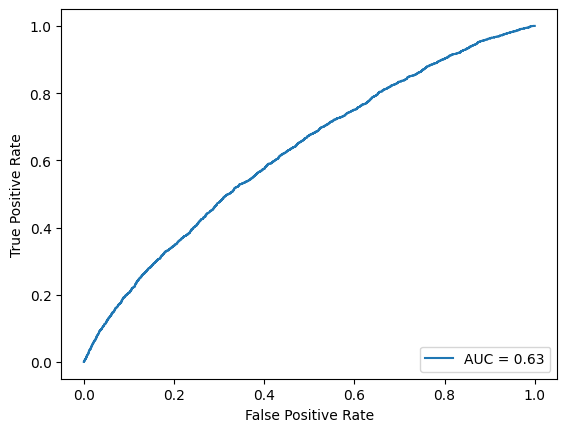

In [10]:
with torch.no_grad():
    print(f"Model : RNN_Based")
    rnn_based.eval()
    pred_y = rnn_based(test_x).squeeze(1)
    pred_y = torch.sigmoid(pred_y)
    result_y = (pred_y > 0.5).long()
    acc = accuracy_score(y_pred = result_y, y_true = test_y)
    precision = precision_score(y_pred = result_y, y_true = test_y, average = 'macro')
    recall = recall_score(y_pred = result_y, y_true = test_y, average = 'macro')
    macro_f1 = f1_score(y_pred = result_y, y_true = test_y, average = 'macro')
    print(f"Accuracy = {acc}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"Macro_F1 = {macro_f1}")
    fpr, tpr, _ = roc_curve(y_true = test_y, y_score = pred_y)
    auc_score = auc(fpr, tpr)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    display_roc.plot()
    plt.show()

In [11]:
lstm_based = LitModel(model = LSTM_based())
lstm_trainer = pl.Trainer(accelerator='gpu', max_epochs = EPOCH, logger=TensorBoardLogger(save_dir='./lightning_logs', name=f"{N}_days_LSTM_based"))
lstm_trainer.fit(model = lstm_based, train_dataloaders = trainLoader, val_dataloaders = valLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\7_days_LSTM_based
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | LSTM_based        | 153 K 
----------------------------------------------
153 K     Trainable params
0         Non-trainable params
153 K     Total params
0.615     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1759/1759 [00:09<00:00, 191.79it/s, loss=0.381, v_num=0, training_loss_step=0.255, val_loss=0.402, training_loss_epoch=0.392]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1759/1759 [00:09<00:00, 191.63it/s, loss=0.381, v_num=0, training_loss_step=0.255, val_loss=0.402, training_loss_epoch=0.392]


Model : LSTM_Based
Accuracy = 0.8554371002132196
Precision = 0.4277185501066098
Recall = 0.5
Macro_F1 = 0.46104343829004824


c:\Users\Wen2Tee5\Desktop\MLProject\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


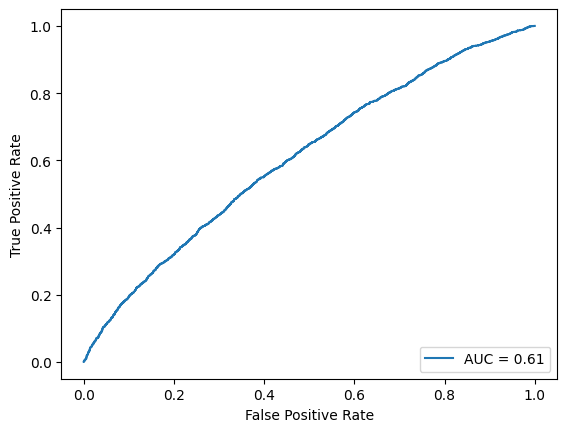

In [12]:
with torch.no_grad():
    print(f"Model : LSTM_Based")
    lstm_based.eval()
    pred_y = lstm_based(test_x).squeeze(1)
    pred_y = torch.sigmoid(pred_y)
    result_y = (pred_y > 0.5).long()
    acc = accuracy_score(y_pred = result_y, y_true = test_y)
    precision = precision_score(y_pred = result_y, y_true = test_y, average = 'macro')
    recall = recall_score(y_pred = result_y, y_true = test_y, average = 'macro')
    macro_f1 = f1_score(y_pred = result_y, y_true = test_y, average = 'macro')
    print(f"Accuracy = {acc}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"Macro_F1 = {macro_f1}")
    fpr, tpr, _ = roc_curve(y_true = test_y, y_score = pred_y)
    auc_score = auc(fpr, tpr)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    display_roc.plot()
    plt.show()

In [13]:
gru_based = LitModel(model = GRU_based())
gru_trainer = pl.Trainer(accelerator='gpu', max_epochs = EPOCH, logger=TensorBoardLogger(save_dir='./lightning_logs', name=f"{N}_days_GRU_based"))
gru_trainer.fit(model = gru_based, train_dataloaders = trainLoader, val_dataloaders = valLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\7_days_GRU_based
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | GRU_based         | 128 K 
----------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.512     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1759/1759 [00:09<00:00, 189.71it/s, loss=0.364, v_num=0, training_loss_step=0.362, val_loss=0.402, training_loss_epoch=0.390]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1759/1759 [00:09<00:00, 189.57it/s, loss=0.364, v_num=0, training_loss_step=0.362, val_loss=0.402, training_loss_epoch=0.390]


Model : GRU_Based
Accuracy = 0.8552949538024165
Precision = 0.5527335418740225
Recall = 0.5001211949206461
Macro_F1 = 0.4614898342871542


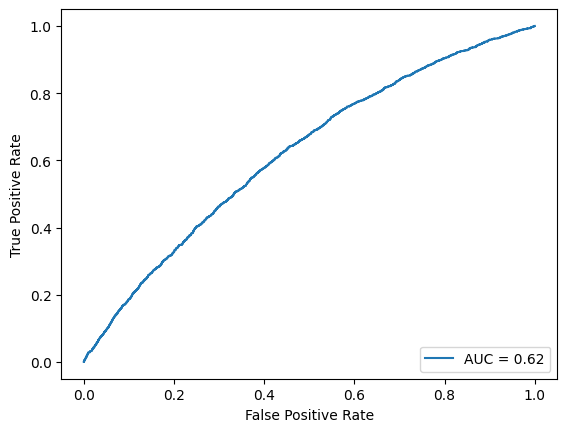

In [14]:
with torch.no_grad():
    print(f"Model : GRU_Based")
    gru_based.eval()
    pred_y = gru_based(test_x).squeeze(1)
    pred_y = torch.sigmoid(pred_y)
    result_y = (pred_y > 0.5).long()
    acc = accuracy_score(y_pred = result_y, y_true = test_y)
    precision = precision_score(y_pred = result_y, y_true = test_y, average = 'macro')
    recall = recall_score(y_pred = result_y, y_true = test_y, average = 'macro')
    macro_f1 = f1_score(y_pred = result_y, y_true = test_y, average = 'macro')
    print(f"Accuracy = {acc}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"Macro_F1 = {macro_f1}")
    fpr, tpr, _ = roc_curve(y_true = test_y, y_score = pred_y)
    auc_score = auc(fpr, tpr)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    display_roc.plot()
    plt.show()

In [15]:
bi_rnn_based = LitModel(model = RNN_based(bi = True))
bi_rnn_trainer = pl.Trainer(accelerator='gpu', max_epochs = EPOCH, logger=TensorBoardLogger(save_dir='./lightning_logs', name=f"{N}_days_BIRNN_based"))
bi_rnn_trainer.fit(model = bi_rnn_based, train_dataloaders = trainLoader, val_dataloaders = valLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\7_days_BIRNN_based
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | RNN_based         | 152 K 
----------------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.612     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1759/1759 [00:10<00:00, 171.50it/s, loss=0.361, v_num=0, training_loss_step=0.382, val_loss=0.400, training_loss_epoch=0.389]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1759/1759 [00:10<00:00, 171.35it/s, loss=0.361, v_num=0, training_loss_step=0.382, val_loss=0.400, training_loss_epoch=0.389]


Model : Bidirectional_RNN_Based
Accuracy = 0.8554371002132196
Precision = 0.4277185501066098
Recall = 0.5
Macro_F1 = 0.46104343829004824


c:\Users\Wen2Tee5\Desktop\MLProject\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


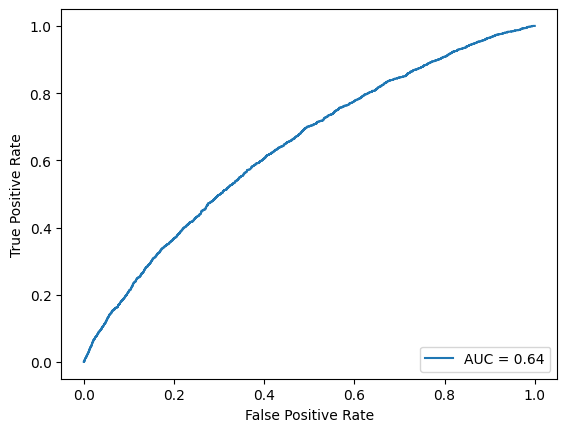

In [16]:
with torch.no_grad():
    print(f"Model : Bidirectional_RNN_Based")
    bi_rnn_based.eval()
    pred_y = bi_rnn_based(test_x).squeeze(1)
    pred_y = torch.sigmoid(pred_y)
    result_y = (pred_y > 0.5).long()
    acc = accuracy_score(y_pred = result_y, y_true = test_y)
    precision = precision_score(y_pred = result_y, y_true = test_y, average = 'macro')
    recall = recall_score(y_pred = result_y, y_true = test_y, average = 'macro')
    macro_f1 = f1_score(y_pred = result_y, y_true = test_y, average = 'macro')
    print(f"Accuracy = {acc}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"Macro_F1 = {macro_f1}")
    fpr, tpr, _ = roc_curve(y_true = test_y, y_score = pred_y)
    auc_score = auc(fpr, tpr)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    display_roc.plot()
    plt.show()

In [17]:
bi_lstm_based = LitModel(model = LSTM_based(bi = True))
bi_lstm_trainer = pl.Trainer(accelerator='gpu', max_epochs = EPOCH, logger=TensorBoardLogger(save_dir='./lightning_logs', name=f"{N}_days_BILSTM_based"))
bi_lstm_trainer.fit(model = bi_lstm_based, train_dataloaders = trainLoader, val_dataloaders = valLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\7_days_BILSTM_based
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | LSTM_based        | 307 K 
----------------------------------------------
307 K     Trainable params
0         Non-trainable params
307 K     Total params
1.230     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1759/1759 [00:10<00:00, 171.45it/s, loss=0.369, v_num=0, training_loss_step=0.327, val_loss=0.399, training_loss_epoch=0.382]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1759/1759 [00:10<00:00, 171.24it/s, loss=0.369, v_num=0, training_loss_step=0.327, val_loss=0.399, training_loss_epoch=0.382]


Bidirectional_LSTM_Based
Accuracy = 0.8554371002132196
Precision = 0.6777438157520614
Recall = 0.5002042790017363
Macro_F1 = 0.461531612705894


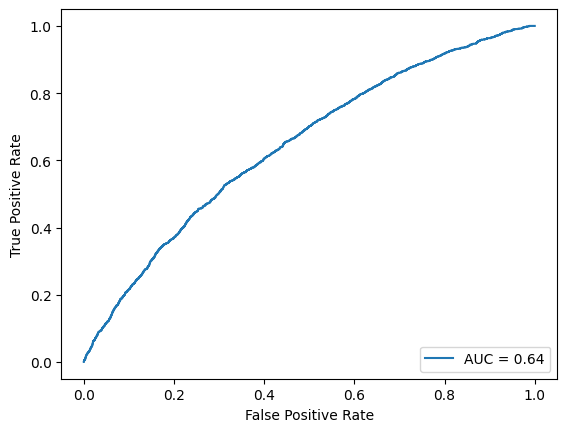

In [18]:
with torch.no_grad():
    print(f"Bidirectional_LSTM_Based")
    bi_lstm_based.eval()
    pred_y = bi_lstm_based(test_x).squeeze(1)
    pred_y = torch.sigmoid(pred_y)
    result_y = (pred_y > 0.5).long()
    acc = accuracy_score(y_pred = result_y, y_true = test_y)
    precision = precision_score(y_pred = result_y, y_true = test_y, average = 'macro')
    recall = recall_score(y_pred = result_y, y_true = test_y, average = 'macro')
    macro_f1 = f1_score(y_pred = result_y, y_true = test_y, average = 'macro')
    print(f"Accuracy = {acc}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"Macro_F1 = {macro_f1}")
    fpr, tpr, _ = roc_curve(y_true = test_y, y_score = pred_y)
    auc_score = auc(fpr, tpr)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    display_roc.plot()
    plt.show()

In [19]:
bi_gru_based = LitModel(model = GRU_based(bi = True))
bi_gru_trainer = pl.Trainer(accelerator='gpu', max_epochs = EPOCH, logger=TensorBoardLogger(save_dir='./lightning_logs', name=f"{N}_days_BIGRU_based"))
bi_gru_trainer.fit(model = bi_gru_based, train_dataloaders = trainLoader, val_dataloaders = valLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs\7_days_BIGRU_based
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | GRU_based         | 255 K 
----------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.024     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1759/1759 [00:10<00:00, 171.06it/s, loss=0.368, v_num=0, training_loss_step=0.227, val_loss=0.395, training_loss_epoch=0.381]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1759/1759 [00:10<00:00, 170.86it/s, loss=0.368, v_num=0, training_loss_step=0.227, val_loss=0.395, training_loss_epoch=0.381]


Bidirectional_GRU_Based
Accuracy = 0.8552949538024165
Precision = 0.427708274097242
Recall = 0.4999169159189099
Macro_F1 = 0.4610021452650935


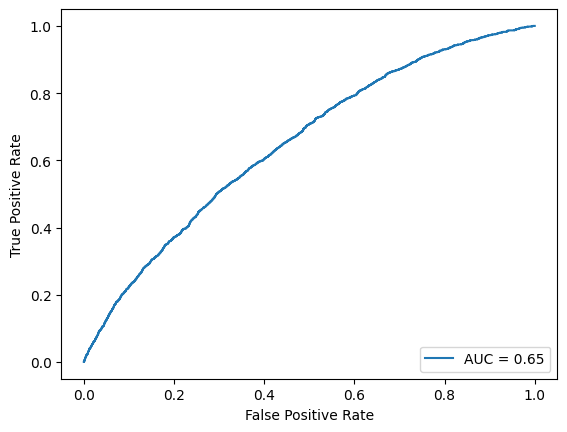

In [20]:
with torch.no_grad():
    print(f"Bidirectional_GRU_Based")
    bi_gru_based.eval()
    pred_y = bi_gru_based(test_x).squeeze(1)
    pred_y = torch.sigmoid(pred_y)
    result_y = (pred_y > 0.5).long()
    acc = accuracy_score(y_pred = result_y, y_true = test_y)
    precision = precision_score(y_pred = result_y, y_true = test_y, average = 'macro')
    recall = recall_score(y_pred = result_y, y_true = test_y, average = 'macro')
    macro_f1 = f1_score(y_pred = result_y, y_true = test_y, average = 'macro')
    print(f"Accuracy = {acc}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"Macro_F1 = {macro_f1}")
    fpr, tpr, _ = roc_curve(y_true = test_y, y_score = pred_y)
    auc_score = auc(fpr, tpr)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    display_roc.plot()
    plt.show()